<a href="https://colab.research.google.com/github/sourangshupal/Yolov5_Custom_Training/blob/main/Roboflow_Custom_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!%cd /content/drive/MyDrive/yolov5setup/dataset/test/
!unzip labels.zip

/bin/bash: line 0: fg: no job control
unzip:  cannot find or open labels.zip, labels.zip.zip or labels.zip.ZIP.


In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 12264, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 12264 (delta 18), reused 22 (delta 13), pack-reused 12229
Receiving objects: 100% (12264/12264), 11.99 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (8488/8488), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
!pip install thop

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 31.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# this is the YAML file
%cat /content/drive/MyDrive/yolov5setup/dataset/data.yaml

train: /content/drive/MyDrive/yolov5setup/dataset/train/images
val: /content/drive/MyDrive/yolov5setup/dataset/test/images

nc: 6
names: ['human','windboard','boat','bouy','sailboat','kayak']

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/drive/MyDrive/yolov5setup/dataset/data.yaml", 'r') as stream:
    print(str(6))



6


In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/drive/MyDrive/yolov5setup/dataset/data.yaml", 'r') as stream:
    num_classes = str(6)

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/drive/MyDrive/yolov5setup/yolov5/models/yolov5m.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/drive/MyDrive/yolov5setup/yolov5/models/custom_yolov5m.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
!cat /content/drive/MyDrive/yolov5setup/dataset/data.yaml

train: /content/drive/MyDrive/yolov5setup/dataset/train/images
val: /content/drive/MyDrive/yolov5setup/dataset/test/images

nc: 6
names: ['human','windboard','boat','bouy','sailboat','kayak']

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/yolov5setup/yolov5
!python train.py --img 416 --batch 16 --epochs 100 --data '/content/drive/MyDrive/yolov5setup/dataset/data.yaml' --weights '/content/drive/MyDrive/yolov5setup/yolov5/runs/train/exp3/weights/best.pt' --cache

/content/drive/MyDrive/yolov5setup/yolov5
github: ⚠️ WARNING: code is out of date by 1113 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='/content/drive/MyDrive/yolov5setup/dataset/data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='/content/drive/MyDrive/yolov5setup/yolov5/runs/train/exp3/weights/best.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 

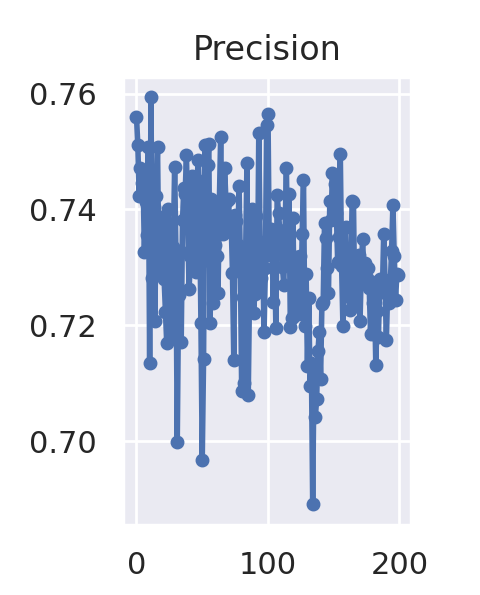

In [ ]:
# we can also output some older school graphs 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/yolov5setup/yolov5/runs/train/exp3/precision-results.png', width=500)  

GROUND TRUTH TRAINING DATA:


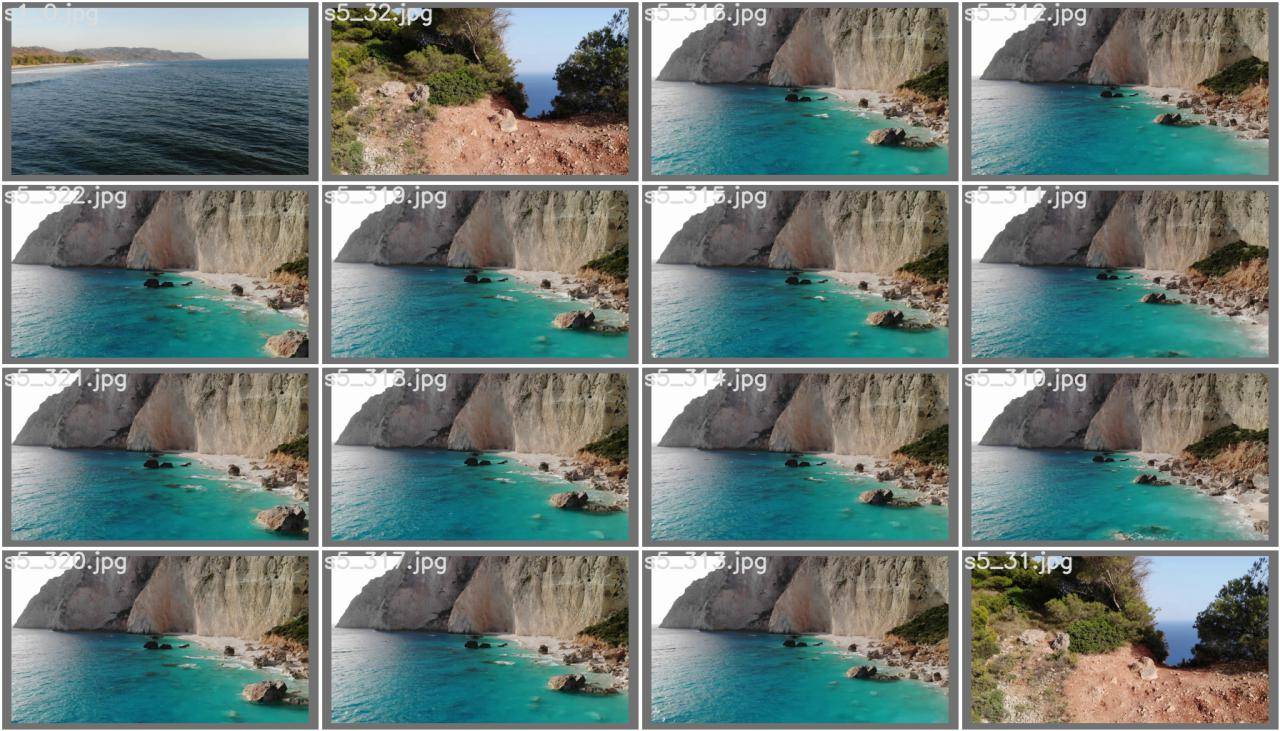

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/yolov5setup/yolov5/runs/train/exp3/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


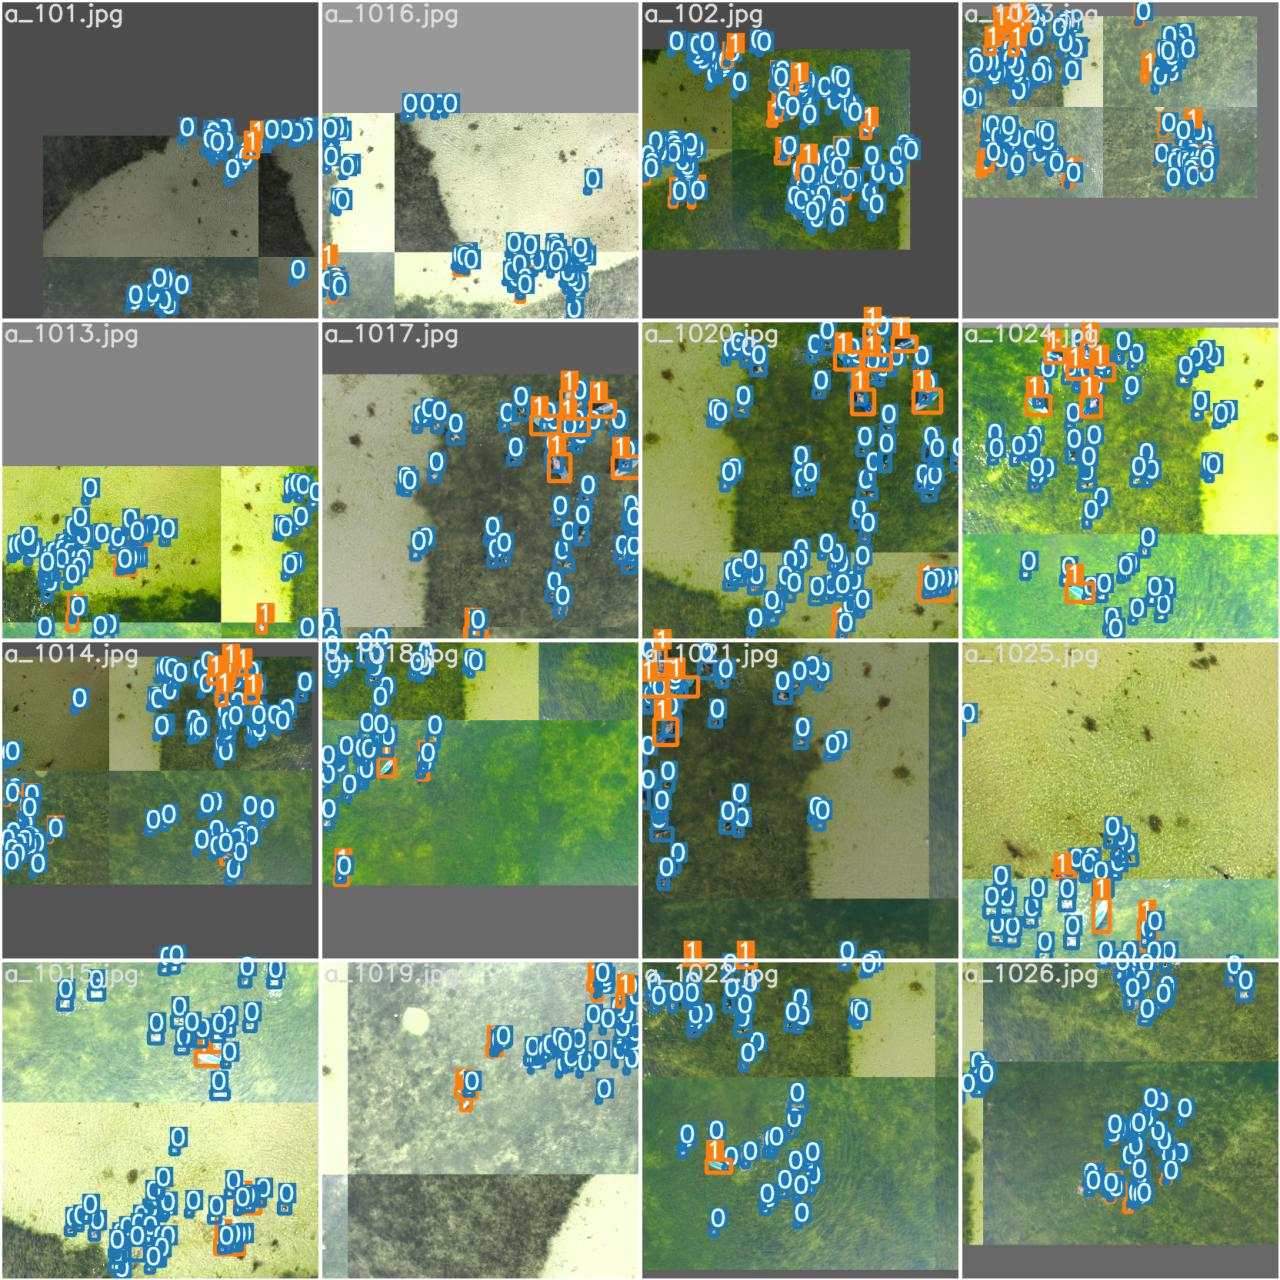

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/drive/MyDrive/yolov5setup/yolov5/runs/train/exp3/train_batch0.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

detect/  train/


In [ ]:
%ls runs/train/exp/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
#%cd /content/yolov5/
!python detect.py --weights runs/train/exp3/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/yolov5setup/dataset/test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/yolov5setup/dataset/test/images', update=False, view_img=False, weights=['runs/train/exp3/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 308 layers, 21057843 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/1405 /content/drive/MyDrive/yolov5setup/dataset/test/images/s1_0.jpg: 256x416 Done. (0.043s)
image 2/1405 /content/drive/MyDrive/yolov5setup/dataset/test/images/s1_1.jpg: 256x416 Done. (0

In [ ]:


import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/yolov5setup/dataset/test/images/w2_38.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Exporting Trained Weights for Future Inference



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/drive/MyDrive/yolov5setup/yolov5/runs/train/exp/weights/best.pt /content/gdrive/My\ Drive

cp: -r not specified; omitting directory '/content/drive/MyDrive/yolov5setup/yolov5/runs/train/yolov5m_results/weights'
